In [93]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import sparse
from scipy.spatial.distance import pdist

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from ipywidgets import interact, FloatRangeSlider

# spacy for language processing
import spacy

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
sns.set_style('white')

In [94]:
path = Path('data', 'bbc')
files = sorted(list(path.glob('**/*.txt')))
doc_list = []
for i, file in enumerate(files):
    topic = file.parts[-2]
    article = file.read_text(encoding='latin1').split('\n')
    heading = article[0].strip()
    body = ' '.join([l.strip() for l in article[1:]]).strip()
    doc_list.append([topic, heading, body])

In [95]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'body'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   topic    2225 non-null   object
 1   heading  2225 non-null   object
 2   body     2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


In [96]:
docs.sample(5)

,topic,heading,body
764,entertainment,Cult band Kasabian surge forward,Indie dance band Kasabian built up a cult foll...
534,entertainment,New Harry Potter tops book chart,Harry Potter and the Half-Blood Prince has top...
297,business,Fannie Mae 'should restate books',US mortgage company Fannie Mae should restate ...
526,entertainment,Spark heads world Booker list,Dame Muriel Spark is among three British autho...
581,entertainment,Box office blow for Alexander,Director Oliver Stone's historical epic Alexan...


In [97]:
docs.topic.value_counts(normalize=True).to_frame('count').style.format({'count': '{:,.2%}'.format})

,count
sport,22.97%
business,22.92%
politics,18.74%
tech,18.02%
entertainment,17.35%


In [98]:
#word count
word_count = docs.body.str.split().str.len().sum()
print(f'Total word cnt: {word_count:,d} | per article: {word_count/len(docs):,.0f}')

Total word cnt: 842,910 | per article: 379


In [99]:
token_count = Counter()
for i, doc in enumerate(docs.body.tolist(), 1):
    if i%1000 == 0:
        print(i, end=' ', flush=True)
    token_count.update([t.strip() for t in doc.split()])

1000 2000 

tockens: token
the     44432
to      24460
of      19756
and     17867
a       17115
in      16316
is       8427
for      8424
that     7528
The      7182
Name: count, dtype: int64


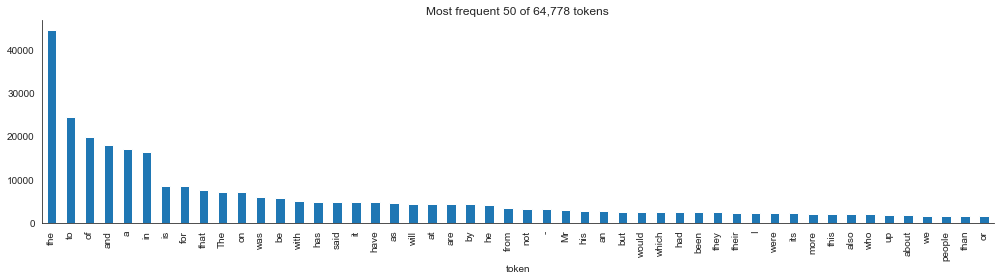

In [100]:
tokens = (pd.DataFrame(token_count.most_common(), columns=['token', 'count']).set_index('token').squeeze())
print(f'tockens: {tokens[:10]}')

n = 50
(tokens.iloc[:50].plot.bar(figsize=(14, 4), title=f'Most frequent {n} of {len(tokens):,d} tokens'))
sns.despine()
plt.tight_layout();

In [101]:
# Document Frequency Distribution
# max_df - to remove word that appears too frequently on documents
binary_vectorizer = CountVectorizer(max_df=1.0, min_df=1, binary=True)

binary_dtm = binary_vectorizer.fit_transform(docs.body)
binary_dtm

<2225x29275 sparse matrix of type '<class 'numpy.int64'>'
	with 445870 stored elements in Compressed Sparse Row format>

In [102]:
n_docs, n_tokens = binary_dtm.shape
tokens_dtm = binary_vectorizer.get_feature_names()
tokens.index.difference(pd.Index(tokens_dtm))

Index(['!', '"', '""unconscionable,', '"'I', '"'Oh', '"'We', '"'You', '"(When',
       '"...it', '"100%',
       ...
       'Â£900m', 'Â£910m).', 'Â£93.6bn)', 'Â£933m', 'Â£947m', 'Â£960m',
       'Â£98)', 'Â£99', 'Â£9m', 'Â£9m,'],
      dtype='object', length=47927)

In [103]:
len(binary_vectorizer.get_feature_names())

29275

In [104]:
results_path = Path('results', 'bbc')
if not results_path.exists():
    results_path.mkdir(parents=True)

dtm_path = results_path / 'binary_dtm.npz'
if not dtm_path.exists():
    sparse.save_npz(dtm_path, binary_dtm)

token_path = results_path / 'tokens.csv'
if not token_path.exists():
    pd.Series(tokens_dtm).to_csv(token_path, index=False)
else:
    tokens = pd.read_csv(token_path, header=None, squeeze=True)

doc_freq = pd.Series(np.array(binary_dtm.sum(axis=0)).squeeze()).div(n_docs)
max_unique_tokens = np.array(binary_dtm.sum(axis=1)).squeeze().max()

In [105]:
df_range = FloatRangeSlider(value=[0.0, 1.0], min=0, max=1, step=0.0001, description='Doc. Freq.',
                            disabled=False, continuous_update=True, orientation='horizontal', readout=True,
                            readout_format='.1%', layout={'width': '800px'})

@interact(df_range=df_range)
def document_frequency_simulator(df_range):
    min_df, max_df = df_range
    keep = doc_freq.between(left=min_df, right=max_df)
    left = keep.sum()

    fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

    updated_dtm = binary_dtm.tocsc()[:, np.flatnonzero(keep)]
    unique_tokens_per_doc = np.array(updated_dtm.sum(axis=1)).squeeze()
    sns.distplot(unique_tokens_per_doc, ax=axes[0], kde=False, norm_hist=False)
    axes[0].set_title('Unique Tokens per Doc')
    axes[0].set_yscale('log')
    axes[0].set_xlabel('# Unique Tokens')
    axes[0].set_ylabel('# Documents (log scale)')
    axes[0].set_xlim(0, max_unique_tokens)
    axes[0].yaxis.set_major_formatter(ScalarFormatter())

    term_freq = pd.Series(np.array(updated_dtm.sum(axis=0)).squeeze())
    sns.distplot(term_freq, ax=axes[1], kde=False, norm_hist=False)
    axes[1].set_title('Document Frequency')
    axes[1].set_ylabel('# Tokens')
    axes[1].set_xlabel('# Documents')
    axes[1].set_yscale('log')
    axes[1].set_xlim(0, n_docs)
    axes[1].yaxis.set_major_formatter(ScalarFormatter())

    title = f'Document/Term Frequency Distribution | # Tokens: {left:,d} ({left/n_tokens:.2%})'
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

interactive(children=(FloatRangeSlider(value=(0.0, 1.0), description='Doc. Freq.', layout=Layout(width='800px'…

In [106]:
m = binary_dtm.todense()
# return most similar article among documents by cosine similarity(can use various metrics)
pairwise_distances = pdist(m, metric='cosine')
closest = np.argmin(pairwise_distances)
rows, cols = np.triu_indices(n_docs)
rows[closest], cols[closest]

(6, 245)

In [107]:
docs.iloc[6].to_frame(6).join(docs.iloc[245].to_frame(245)).to_csv(results_path / 'most_similar.csv')
docs.iloc[6]

topic                                               business
heading                     Jobs growth still slow in the US
body       The US created fewer jobs than expected in Jan...
Name: 6, dtype: object

In [108]:
pd.DataFrame(binary_dtm[[6, 245], :].todense()).sum(0).value_counts()

0    28972
1      265
2       38
dtype: int64

In [109]:
# Baseline: number of unique tokens
vectorizer = CountVectorizer() # default: binary=False
doc_term_matrix = vectorizer.fit_transform(docs.body)
doc_term_matrix

<2225x29275 sparse matrix of type '<class 'numpy.int64'>'
	with 445870 stored elements in Compressed Sparse Row format>

In [110]:
doc_term_matrix.shape

(2225, 29275)

In [111]:
# vectorizer keeps words
words = vectorizer.get_feature_names()
words[:10]

['00',
 '000',
 '0001',
 '000bn',
 '000m',
 '000s',
 '000th',
 '001',
 '001and',
 '001st']

In [112]:
# from scipy compressed sparse row matrix to sparse DataFrame
doc_term_matrix_df = pd.DataFrame.sparse.from_spmatrix(doc_term_matrix, columns=words)
doc_term_matrix_df.head()

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,zooms,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zutons,zvonareva,zvyagintsev
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
# Most frequent terms
word_freq = doc_term_matrix_df.sum(axis=0).astype(int)
word_freq.sort_values(ascending=False).head()

the    52574
to     24767
of     19930
and    18574
in     17553
dtype: int32

In [114]:
# Compute relative term frequency
vectorizer = CountVectorizer(binary=True)
doc_term_matrix = vectorizer.fit_transform(docs.body)
doc_term_matrix.shape

(2225, 29275)

In [115]:
words = vectorizer.get_feature_names()
word_freq = doc_term_matrix.sum(axis=0)

# reduce to 1D array
word_freq_1d = np.squeeze(np.asarray(word_freq))

pd.Series(word_freq_1d, index=words).div(docs.shape[0]).sort_values(ascending=False).head(10)

the     1.000000
to      0.995056
of      0.991461
and     0.991011
in      0.990562
for     0.930337
on      0.906517
is      0.862472
it      0.858427
said    0.848539
dtype: float64

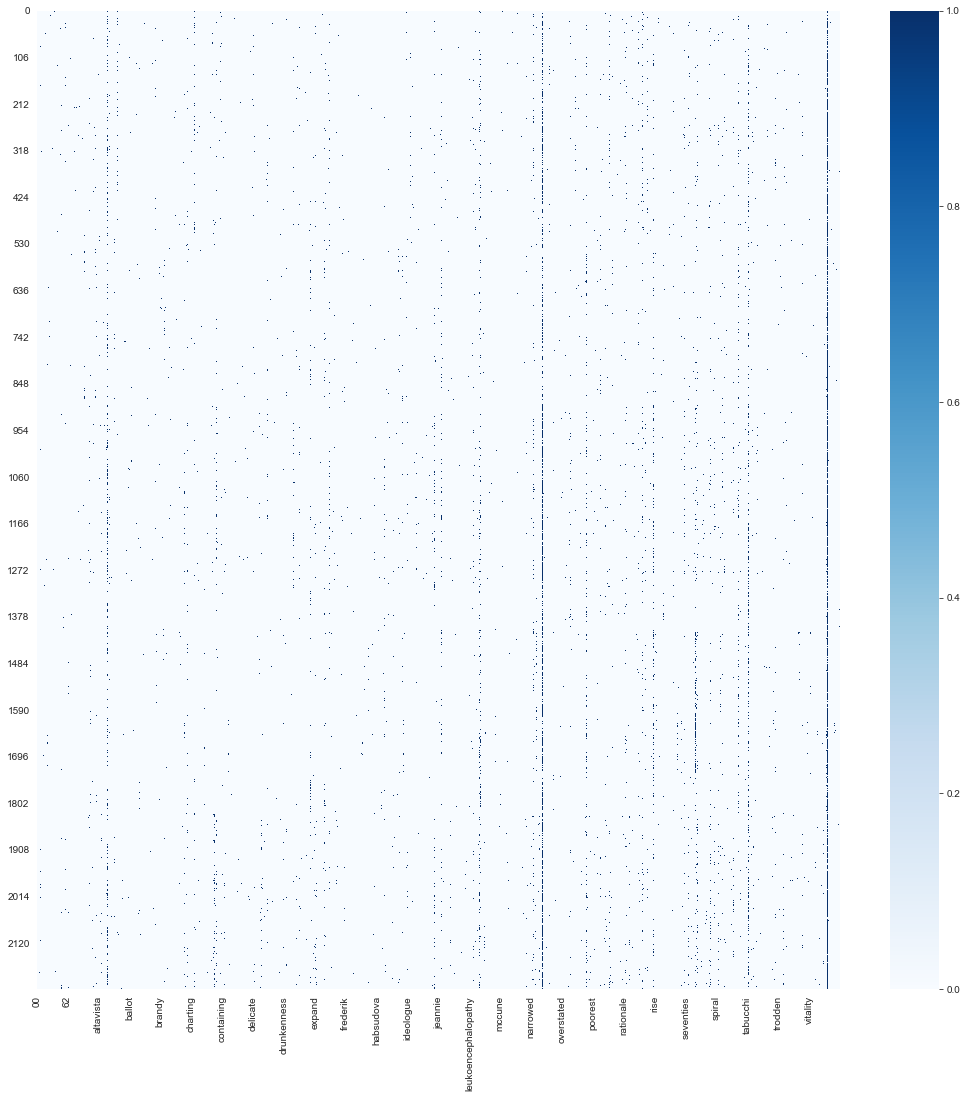

In [116]:
# Visualize Doc-Term Matrix
sns.heatmap(pd.DataFrame(doc_term_matrix.todense(), columns=words), cmap='Blues')
plt.gcf().set_size_inches(18, 18);

In [117]:
# Using thresholds to reduce the number of tokens
vectorizer = CountVectorizer(max_df=.2, min_df=3, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(docs.body)
doc_term_matrix.shape

(2225, 12789)

In [118]:
# Building a custom tokenizer for Lemmatization with spacy
# Lemmatization considers words and the part of speech. Whereas, the word only for stemming.
nlp = spacy.load('en_core_web_sm')
def tokenizer(doc):
    return [w.lemma_ for w in nlp(doc) if not w.is_punct | w.is_space]

vectorizer = CountVectorizer(tokenizer=tokenizer, binary=True)
doc_term_matrix = vectorizer.fit_transform(docs.body)
doc_term_matrix.shape

(2225, 25216)

In [119]:
lemmatized_words = vectorizer.get_feature_names()
word_freq = doc_term_matrix.sum(axis=0)
word_freq_1d = np.squeeze(np.asarray(word_freq))
word_freq_1d = pd.Series(word_freq_1d, index=lemmatized_words).div(docs.shape[0])
word_freq_1d.sort_values().tail(20)

from    0.702022
but     0.732135
as      0.742022
by      0.765843
at      0.792809
with    0.824719
that    0.830562
it      0.858427
say     0.881798
's      0.895730
on      0.906517
for     0.930337
have    0.971236
in      0.990562
and     0.991011
of      0.991461
a       0.992809
to      0.995056
be      0.998202
the     1.000000
dtype: float64

In [120]:
sample_docs = ['call you tomorrow', 'Call me a taxi', 'please call me... PLEASE!']

In [121]:
# Compute term frequency
vectorizer = CountVectorizer()
tf_dtm = vectorizer.fit_transform(sample_docs).todense()
tokens = vectorizer.get_feature_names()
term_frequency = pd.DataFrame(data=tf_dtm, columns=tokens)
print(term_frequency)

   call  me  please  taxi  tomorrow  you
0     1   0       0     0         1    1
1     1   1       0     1         0    0
2     1   1       2     0         0    0


In [122]:
# Compute document frequency
vectorizer = CountVectorizer(binary=True)
df_dtm = vectorizer.fit_transform(sample_docs).todense().sum(axis=0)
document_frequency = pd.DataFrame(data=df_dtm, columns=tokens)
print(document_frequency)

   call  me  please  taxi  tomorrow  you
0     3   2       1     1         1    1


In [123]:
# Compute TfIDF
tfidf = pd.DataFrame(data=tf_dtm/df_dtm, columns=tokens)
print(tfidf)

       call   me  please  taxi  tomorrow  you
0  0.333333  0.0     0.0   0.0       1.0  1.0
1  0.333333  0.5     0.0   1.0       0.0  0.0
2  0.333333  0.5     2.0   0.0       0.0  0.0


In [150]:
# for smoothing effect - smooth_idf(+1) and sublinear_tf(1+log(tf))
vect = TfidfVectorizer(smooth_idf=True, norm='l2', # squared weights sum to 1 by document
                       sublinear_tf=False,   # if True, use 1+log(tf)
                       binary=False)
print(pd.DataFrame(vect.fit_transform(sample_docs).todense(), columns=vect.get_feature_names()))

       call        me    please      taxi  tomorrow       you
0  0.385372  0.000000  0.000000  0.000000  0.652491  0.652491
1  0.425441  0.547832  0.000000  0.720333  0.000000  0.000000
2  0.266075  0.342620  0.901008  0.000000  0.000000  0.000000


In [125]:
# TfIDF with new articles
tfidf = TfidfVectorizer(stop_words='english')
dtm_tfidf = tfidf.fit_transform(docs.body)
tokens = tfidf.get_feature_names()
dtm_tfidf.shape

(2225, 28980)

In [152]:
token_freq = (pd.DataFrame({'tfidf': dtm_tfidf.sum(axis=0).A1, 'token': tokens})
              .sort_values('tfidf', ascending=False))
token_freq.head(10).append(token_freq.tail(10)).set_index('token')

,tfidf
token,
said,87.251494
mr,58.220783
year,41.982178
people,37.303707
new,34.197388
film,29.728250
government,28.792651
world,27.031199
time,26.358319


In [127]:
# Summarizing news articles using TfIDF weights
article = docs.sample(1).squeeze()
article_id = article.name
print(f'Topic:\t{article.topic.capitalize()}\n\n{article.heading}\n')
print(article.body.strip())

Topic:	Tech

Sony PSP tipped as a 'must-have'

Sony's Playstation Portable is the top gadget for 2005, according to a round-up of ultimate gizmos compiled by Stuff Magazine.  It beats the iPod into second place in the Top Ten Essentials list which predicts what gadget-lovers are likely to covet this year. Owning all 10 gadgets will set the gadget lover back Â£7,455. That is Â£1,000 cheaper than last year's list due to falling manufacturing costs making gadgets more affordable.  Portable gadgets dominate the list, including Sharp's 902 3G mobile phone, the Pentax Optio SV digital camera and Samsung's Yepp YH-999 video jukebox.  "What this year's Essentials shows is that gadgets are now cheaper, sexier and more indispensable than ever. We've got to the point where we can't live our lives without certain technology," said Adam Vaughan, editor of Stuff Essentials. The proliferation of gadgets in our homes is inexorably altering the role of the high street in our lives thinks Mr Vaughan. "T

In [128]:
# Select most relevant tokens by tfidf value
article_tfidf = dtm_tfidf[article_id].todense().A1
article_tokens = pd.Series(article_tfidf, index=tokens)
article_tokens.sort_values(ascending=False).head(10)

gadgets       0.339949
essentials    0.291426
gadget        0.265057
list          0.205897
stuff         0.201818
vaughan       0.179435
dominate      0.159211
lovers        0.155889
predicts      0.145656
cheaper       0.134545
dtype: float64

In [129]:
# Compare to random selection
pd.Series(article.body.split()).sample(10).tolist()

['film',
 'in',
 'year.',
 'to',
 'of',
 "year's",
 'mobile',
 'gadgets',
 'he',
 'photos?']

In [130]:
# Create Train & Test Sets - Stratified train_test_split
train_docs, test_docs = train_test_split(docs, stratify=docs.topic, test_size=50, random_state=42)
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [131]:
pd.Series(test_docs.topic).value_counts()

sport            12
business         11
entertainment     9
tech              9
politics          9
Name: topic, dtype: int64

In [132]:
# Vectorize train & test sets
vectorizer = CountVectorizer(max_df=.2, min_df=3, stop_words='english', max_features=2000)

train_dtm = vectorizer.fit_transform(train_docs.body)
words = vectorizer.get_feature_names()
train_dtm

<2175x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 178762 stored elements in Compressed Sparse Row format>

In [133]:
test_dtm = vectorizer.transform(test_docs.body)
test_dtm

<50x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 4048 stored elements in Compressed Sparse Row format>